In [50]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial
from astropy.stats import SigmaClip
import pandas as pd

In [51]:
## This code was used to extract the files

import tarfile
import os

# Path to the tar.gz file
file_path = 'keck.tar.gz'
extract_path = 'extracted_files'

# Extract the .tar.gz file
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)
    print(f"Extracted files to: {extract_path}")





Extracted files to: extracted_files


In [52]:
## Separate the Star and Phases using there names

template_stars = ['keck_m0','keck_g5','keck_g9','keck_k0','keck_k1',
                  'keck_k2','keck_k4', 'keck_k5','keck_k7','keck_k8']

GS_2000 = ['keck_gs2000_01','keck_gs2000_02','keck_gs2000_03','keck_gs2000_04','keck_gs2000_05','keck_gs2000_06',
           'keck_gs2000_07','keck_gs2000_08','keck_gs2000_09','keck_gs2000_10','keck_gs2000_11','keck_gs2000_12',
          'keck_gs2000_13']

phases = np.array([-0.1405, -0.0583, 0.0325, 0.0998, 0.1740, 0.2310, 0.3079, 
                   0.3699, 0.4388, 0.5008, 0.5698, 0.6371, 0.7276])

In [69]:
### Data extraction for each star template
import os
import numpy as np

# Path to the folder containing the .dat files
folder_path = 'extracted_files'

# Initialize a dictionary to store data from each file
data_dict = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("keck_") and filename.endswith(".dat"):
        file_path = os.path.join(folder_path, filename)
        
        # Load the data assuming three columns: wavelength, flux, flux uncertainty
        try:
            data = np.loadtxt(file_path)  # Automatically splits by whitespace
            wavelength = data[:, 0]      # First column
            flux = data[:, 1]            # Second column
            flux_uncertainty = data[:, 2]  # Third column
            
            # Save the data into a dictionary
            data_dict[filename[:-4]] = {
                "wavelength": wavelength,
                "flux": flux,
                "flux_uncertainty": flux_uncertainty,
            }
        except Exception as e:
            continue



$
\huge \text{Report: Hunting a Black Hole in GS2000}
$

In the following Jupyter notebook, we analyse the close binary system GS2000, where a star orbits a compact object which could a black hole. the maximum mass of a neutron star is three solar masses. If we can estimate the mass as above this we can determine it is likely a black hole.

In order to do this we analyse the 13 spectra from GS2000 from different phases and compare these with template stars to determine the radial velocity of the star. Using this, we can use kepler's law and monte carlo simulation informed by our template spectrum to determine the mass of the compact object.

$
\large \text{Plots: Normalised Template Star Spectra}
$

In order to plot the normalised template star, we need to find the continuum level and divide the spectrum by this. This will allow us to examine more clearly the absorption lines and compare them to our target star.

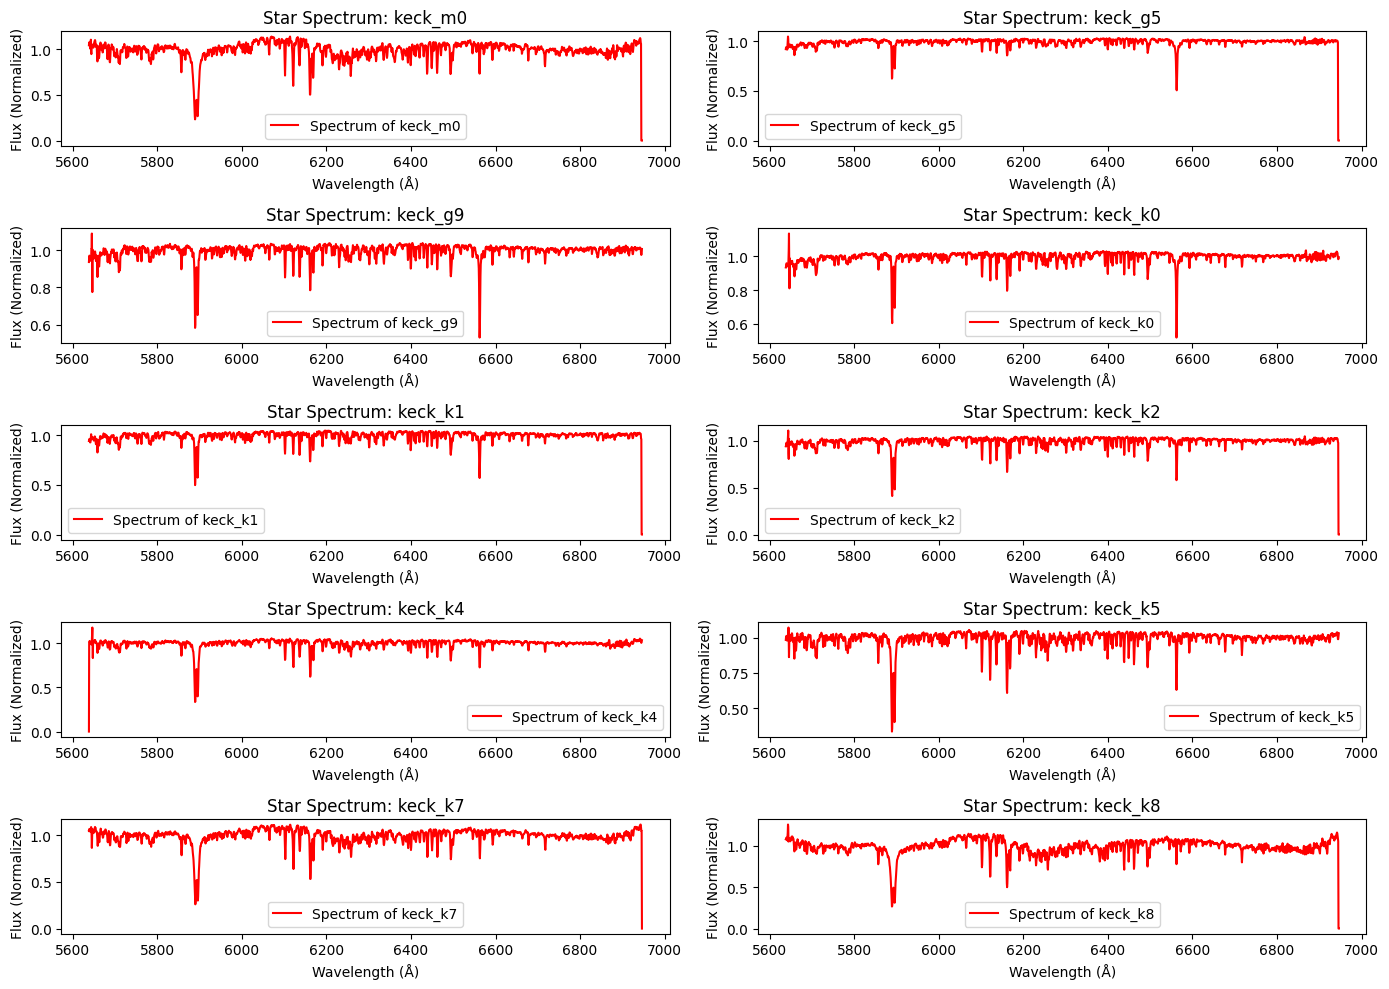

In [54]:
### Polynomial fitting with a sigma clip which masks absorption and emission lines
### While fitting the continuum level
def polynomial_fit_with_sigma_clipping(x, y, degree=5, nsigma=2, max_iterations=50):
    """
    Perform polynomial fitting with sigma clipping for continuum estimation.
    
    Parameters:
        x (array): Independent variable (e.g., wavelength).
        y (array): Dependent variable (e.g., flux).
        degree (int): Degree of the polynomial to fit.
        nsigma (float): Sigma threshold for clipping.
        max_iterations (int): Maximum number of sigma-clipping iterations.
    
    Returns:
        poly (Polynomial): Fitted polynomial object.
        mask (array): Boolean mask of the final points used for fitting.
    """
    sigma_clip = SigmaClip(sigma=2, cenfunc='mean', stdfunc='std', maxiters=50)
    clipped_data = sigma_clip(y)
    clipped_data_2 = clipped_data.compressed()
    wavelength_clipped = wavelength[~(clipped_data.mask)]
    coeff = np.polyfit(wavelength_clipped,clipped_data_2,5)
    polynomial = np.poly1d(coeff)

    return polynomial

# Number of stars
num_stars = len(template_stars)

# Create a grid of subplots with 2 plots per row
rows = (num_stars + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 2))
axes = axes.flatten()

template_normalised_flux = []
# Loop through each star and its corresponding subplot
for i, star in enumerate(template_stars):
    wavelength = data_dict[star]['wavelength']
    flux = data_dict[star]['flux']

    # Fit polynomial and mask outliers
    poly = polynomial_fit_with_sigma_clipping(wavelength, flux, degree=3, nsigma=3)
    y_fit = poly(wavelength)

    # Normalise the flux
    normalised_flux = flux / y_fit
    template_normalised_flux.append(normalised_flux)

    # Plot the spectrum and the fitted continuum
    axes[i].plot(wavelength, normalised_flux, label=f"Spectrum of {star}", color='r')
    axes[i].set_xlabel("Wavelength (Å)")
    axes[i].set_ylabel("Flux (Normalized)")
    axes[i].set_title(f"Star Spectrum: {star}")
    axes[i].legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


Plotting these normalised plots will allow us to compare them with the target star and decide which to use as our fit for determine the velocity of our target star.

$
\large \text{Plots: 13 Spectra of GS2000 ordered by binary phase}
$

These plots will show the basic feautres of our target star

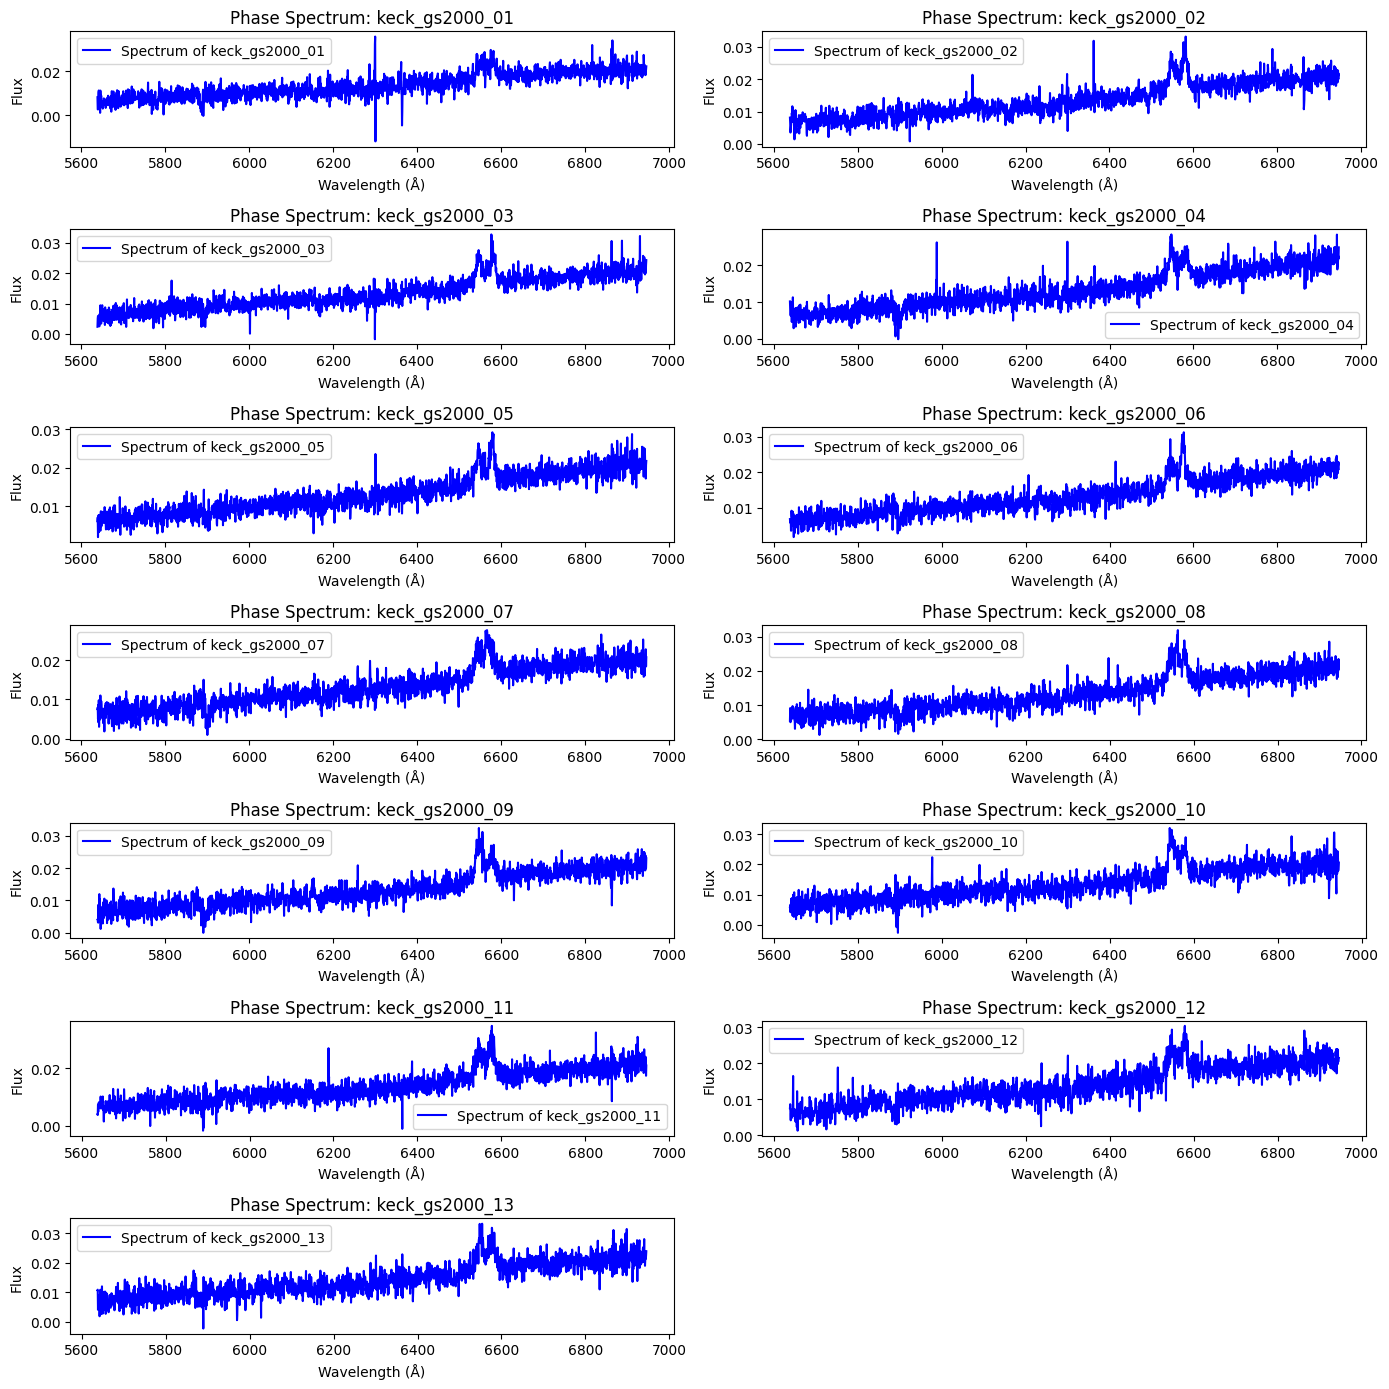

In [55]:
# Number of stars
num_phases = len(GS_2000)

# Create a grid of subplots with 2 plots per row
rows = (num_phases + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 2))  # Adjust figure size for clarity
axes = axes.flatten()

normalized_fluxes = []
# Loop through each star and its corresponding subplot
for i, phase in enumerate(GS_2000):
    wavelength = data_dict[phase]['wavelength']
    flux = data_dict[phase]['flux']

    fit = polynomial_fit_with_sigma_clipping(wavelength,flux)
    
    y_fine = fit(wavelength)
    normalized_fluxes.append(flux/y_fine)
    # Plot the spectrum
    axes[i].plot(wavelength, flux, label=f"Spectrum of {phase}", color="blue")
    #axes[i].plot(wavelength, y_fine, label=f"Continuum fit of {phase}", color="orange")
    axes[i].set_xlabel("Wavelength (Å)")
    axes[i].set_ylabel("Flux")
    axes[i].set_title(f"Phase Spectrum: {phase}") 
    axes[i].legend()

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


As we can see from the spectra there is a strong H$\alpha$ emisson line present in the data around the wavelength 6530 Å, we can also see the vague outline of the Na D absoprtion line between 5800 and 6000 Å.

$
\large \text{Plot: 13 Normalised Spectra of GS2000 ordered by binary phase}
$

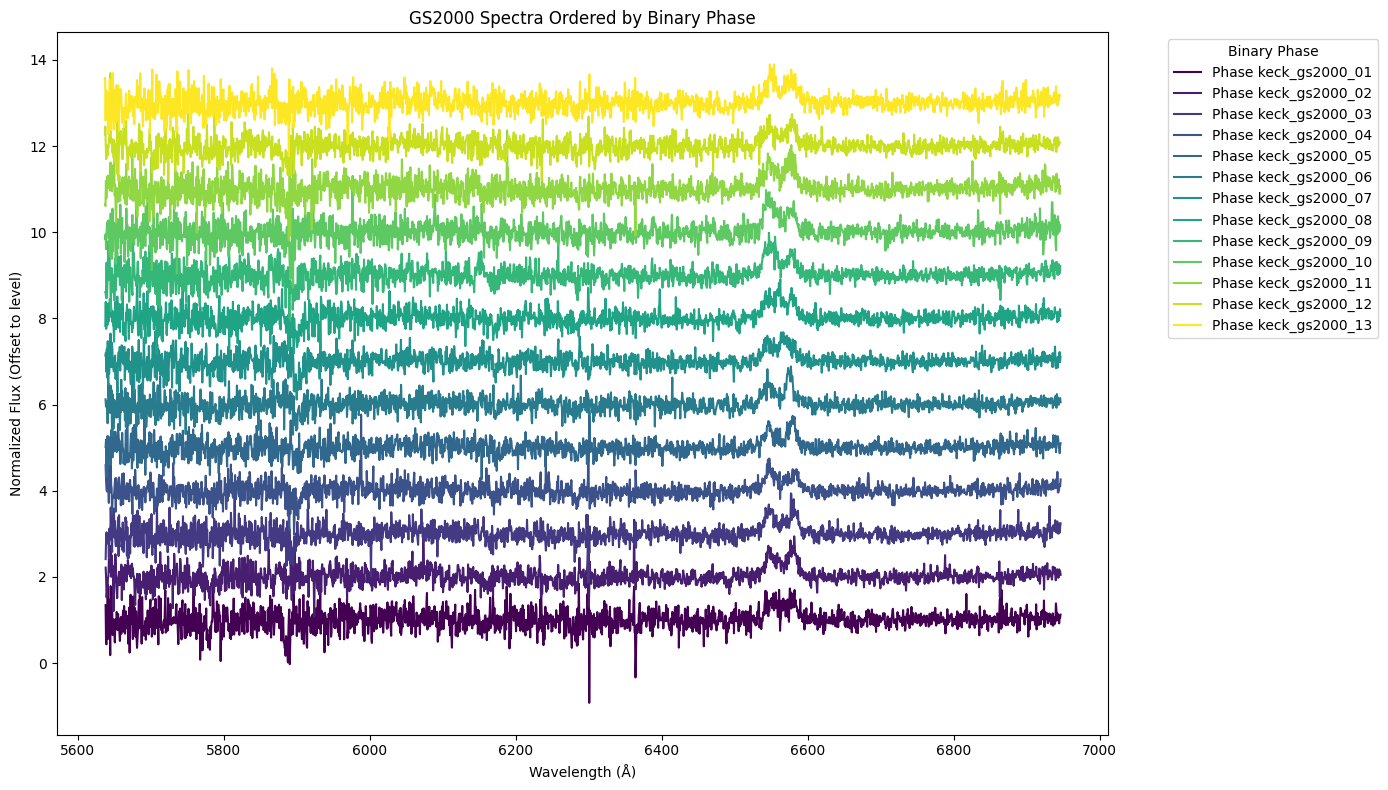

In [56]:
# Normalize and order by phase, then plot all spectra in a single figure
plt.figure(figsize=(14, 8))

# Define colors for the phases
colors = plt.cm.viridis(np.linspace(0, 1, len(GS_2000)))

# Loop through each phase, normalize, and plot
for i, (phase, color) in enumerate(zip(GS_2000, colors)):
    wavelength = data_dict[phase]['wavelength']
    flux = data_dict[phase]['flux']

    # Normalize the flux using cubic spline fitting
    fit = polynomial_fit_with_sigma_clipping(wavelength, flux)
    y_fine = fit(wavelength)
    normalized_flux = flux / y_fine

    # Plot the normalized spectrum with phase label
    plt.plot(wavelength, normalized_flux + i, color=color, label=f"Phase {phase}")

# Add labels and customize
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Flux (Offset to level)")
plt.title("GS2000 Spectra Ordered by Binary Phase")
plt.legend(title="Binary Phase", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

This plot shows concisely the change in the normalised spectra of the 13 phases as there phase changes. It is clearly that the data changes but an obvious shift in the data or clear trend with changing phase can not be seen.

$
\large \text{Plot: Average GS2000 Spectrum over the binary Phases, showing the Na D absorption line}
$

We plot the average of the spectra to get an idea of the general features such as emission and absorption lines.

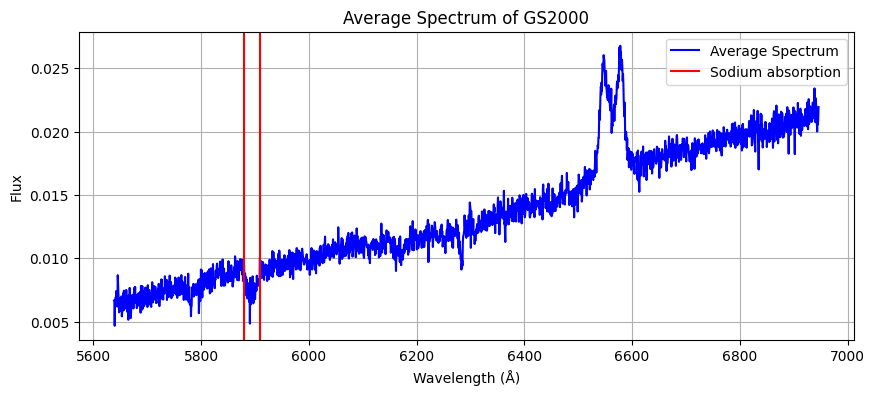

In [57]:

wavelength = data_dict[GS_2000[0]]["wavelength"]  
flux_matrix = []

# Loop through all phases to collect fluxes
for phase in GS_2000:
    flux_matrix.append(data_dict[phase]["flux"])

flux_matrix = np.array(flux_matrix) 

# Compute the average flux for each wavelength
average_flux = np.mean(flux_matrix, axis=0)  # Mean across phases 

# Plot the average spectrum
plt.figure(figsize=(10, 4))
plt.plot(wavelength, average_flux, label="Average Spectrum", color="blue")
plt.axvline(5880, color='r', label='Sodium absorption')
plt.axvline(5910, color='r')
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Average Spectrum of GS2000")
plt.legend()
plt.grid()
plt.show()


From the average flux it is even more clear that there is an absorption line/lines around 5890/5896 Å, this corresponds to the Na D. This absorption line is most strongly seen in K and M types stars like those in our template spectra.

$
\large \text{Plot: Comparing the average normalised flux of GS2000 to the chosen template K5}
$

We will see that they share some common features but a shift in the data is clearly necessary as expected.

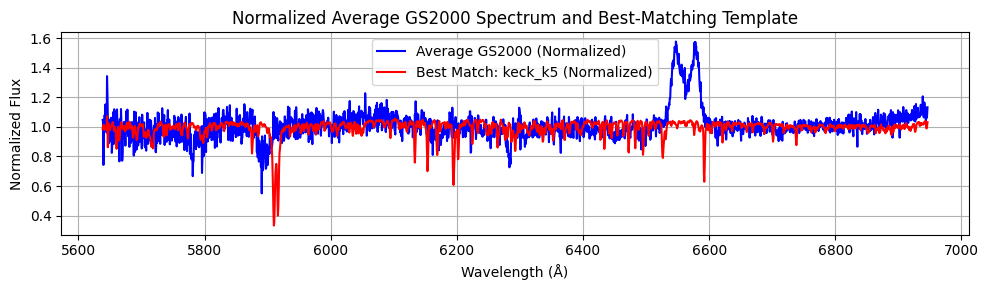

In [58]:

## Take the mean of the normalized fluxes
average_normalised_flux = np.mean(normalized_fluxes, axis=0)  

## Select K_5 as our star of choice as the pattern matches well our spectrum
## though it is hard to do and analysis was peformed on a few
suit_star = template_stars[7]
index = 7

        
## Plot the normalized template flux
plt.figure(figsize=(10, 3))
plt.plot(wavelength, average_normalised_flux, label="Average GS2000 (Normalized)", color="blue")
# Plot the normalized best-matching template spectrum
plt.plot(wavelength, template_normalised_flux[index], label=f"Best Match: {suit_star} (Normalized)", color="red")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized Flux")
plt.title("Normalized Average GS2000 Spectrum and Best-Matching Template")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



Here we can see how some of the spectral lines, for example around the Na D absorption might be shift to fit the spectrums of GS_2000. 

In [59]:
## In this Cell we compute the normlised fluxes for the template star and all the phases of GS_2000

subtracted_fluxes = []
normalised_sigma = []


# Loop through each phase and calculate the normalised flux and uncertainty
for i, phase in enumerate(GS_2000):
    wavelength = np.array(data_dict[phase]['wavelength'])
    flux = np.array(data_dict[phase]['flux'])
    sigma = np.array(data_dict[phase]['flux_uncertainty'])
    polynomial = polynomial_fit_with_sigma_clipping(wavelength, flux)
    
    y_fine = polynomial(wavelength)
    subtracted_fluxes.append(flux/y_fine)
    normalised_sigma.append(sigma/y_fine)


wavelength = data_dict[suit_star]['wavelength']
flux = data_dict[suit_star]['flux']
polynomial = polynomial_fit_with_sigma_clipping(wavelength, flux)
y_fine = polynomial(wavelength)
subtracted_fluxes_suit_star = flux/y_fine




$
\large \text{Plot: Excluded Mask Region in analysis to avoid fitting to the H}\alpha \text{ emission}
$

Having exmained the two graphs it is clear the the H$\alpha$ emission is not from the star itself hence it is best to ignore this part of the spectrum.

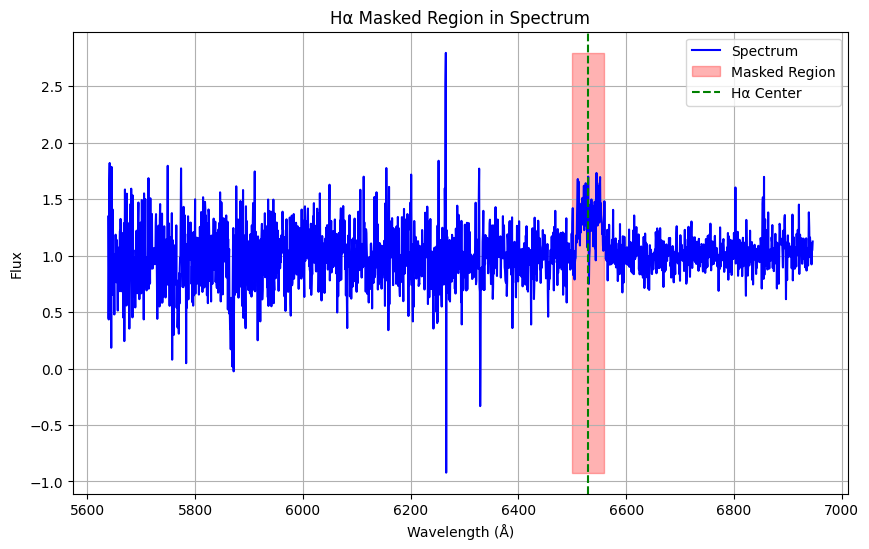

In [60]:
## Center of the mask
ha_center = 6530  
## Width to mask around Hα
delta_lambda = 30 
mask_range = (wavelength >= ha_center - delta_lambda) & (wavelength <= ha_center + delta_lambda)


plt.figure(figsize=(10, 6))
plt.plot(wavelength, subtracted_fluxes[0], label="Spectrum", color='blue')
# Highlight the masked region
plt.fill_between(
    wavelength, subtracted_fluxes[0].min() - 0.001, subtracted_fluxes[0].max() + 0.001,
    where=mask_range,
    color='red', alpha=0.3, label="Masked Region"
)

# Mark the center of the Hα line
plt.axvline(ha_center, color='green', linestyle='--', label="Hα Center")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title("Hα Masked Region in Spectrum")
plt.legend()
plt.grid(True)
plt.show()


The analysis should now be directly comparing the absorption spectra of the two stars.

$
\large \text{Plots: Chi-squared vs Velocity: showing the the velocity fitting}
$

We can now use cross correlation analysis to determine the $\chi^2$ distribution for as given velocity, we will then look to find the minimum $\chi^2$ for a range of velocities shifts. This will be done for every phase measured so we can determine the relationship between the velocity and the phase.

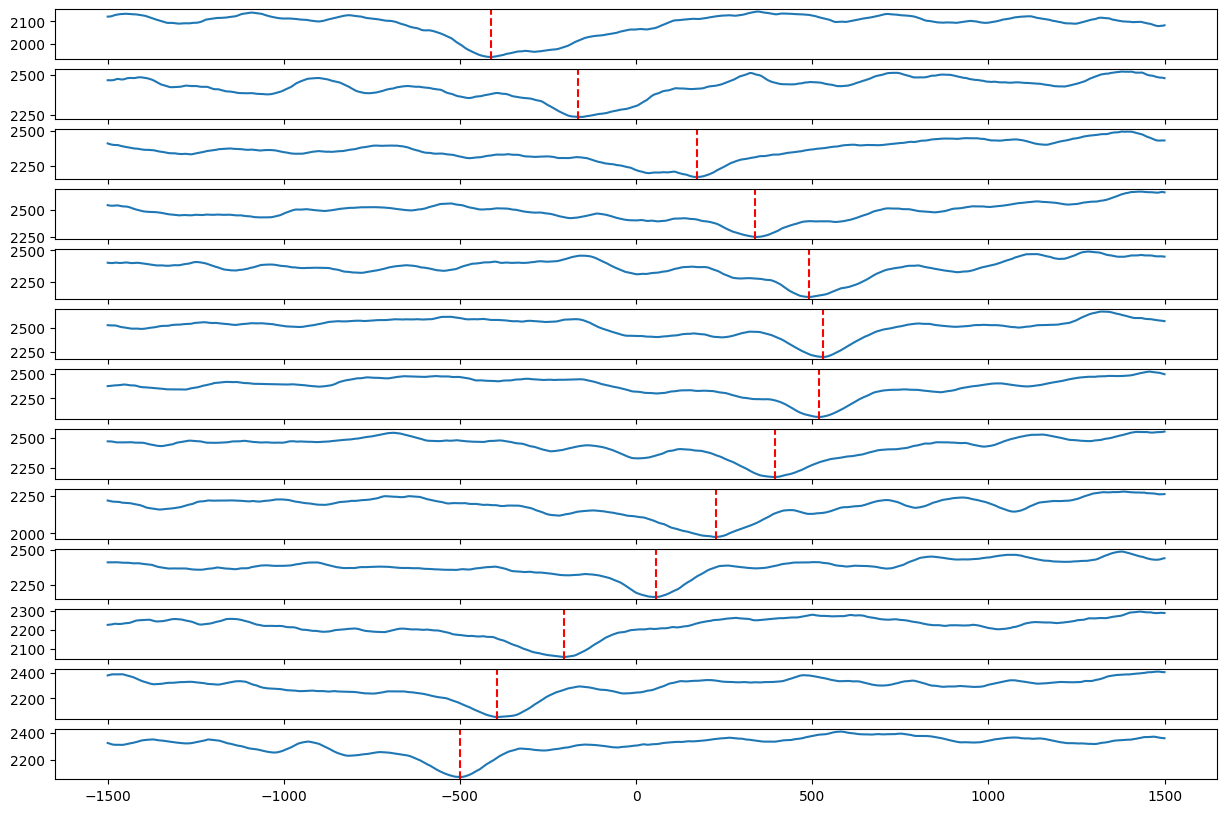

In [61]:
# Define the velocity ranges
velocities = np.linspace(-1.5*10**3,1.5*10**3,10000)

subtracted_fluxes_suit_star = np.array(subtracted_fluxes_suit_star)
### Chi minimser calculates the CCF and then uses this to find chi
def chi_minimser(flux,wavelength, sigma,vs):
    CCFs = []
    chi_squared = []
    for i in range(len(vs)):
        # Shift the wavelength
        shifted_w = data_dict[suit_star]["wavelength"][~mask_range] * (1 + (vs[i]/3e5))
        ## Reinterpolate the flux on wavelength grid
        shifted_flux = np.interp(wavelength, shifted_w,subtracted_fluxes_suit_star[~mask_range])
        ## Calculate CCF
        CCF = np.sum((shifted_flux * flux)/(sigma**2)) / np.sum((shifted_flux**2)/(sigma**2))
        CCFs.append(CCF)
        ## Calculate Chi
        chi_squared.append(np.sum(((shifted_flux * CCF - flux)**2)/(sigma**2)))
    return CCFs, chi_squared

## Plot chi vs velocity and show the minimum velocity
approx_vs = []
fig, axes = plt.subplots(13, 1, figsize = (15,10))
for i,phase in enumerate(GS_2000):
    chi = chi_minimser(np.array(subtracted_fluxes[i][~mask_range]),np.array(data_dict[phase]["wavelength"][~mask_range]), np.array(normalised_sigma[i][~mask_range]),velocities)[1]
    axes[i].plot(velocities,chi)
    approx_v = velocities[np.argmin(chi)]
    approx_vs.append(approx_v)
    axes[i].axvline(approx_v, color='r', linestyle='--')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

Here we have calculated the chi-squared distribution for many different velocity shifts of the template star, finding the minimum of this will tell us the velocity of the target star in each phase.

$
\large \text{Plots: Chi-squared vs Velocity: showing the the velocity fitting}
$

In these plots we show clearly the lines $\chi^2_{min} + 1$ used to determine the uncertainty.

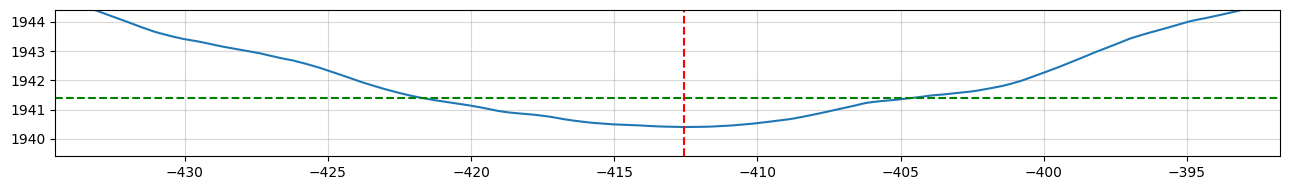

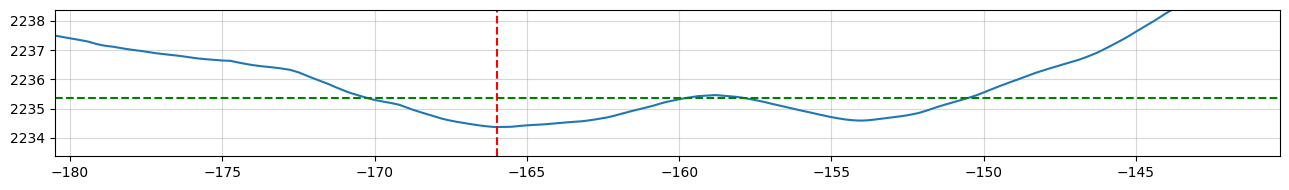

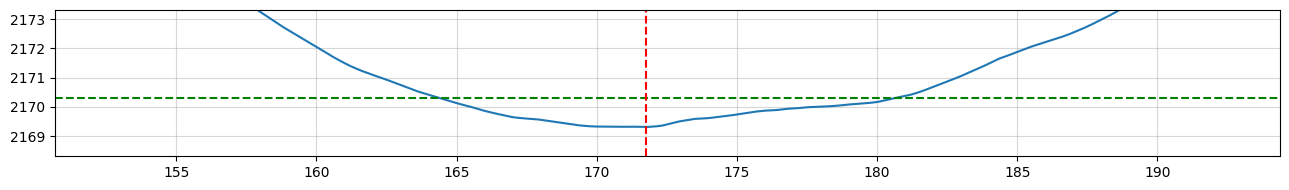

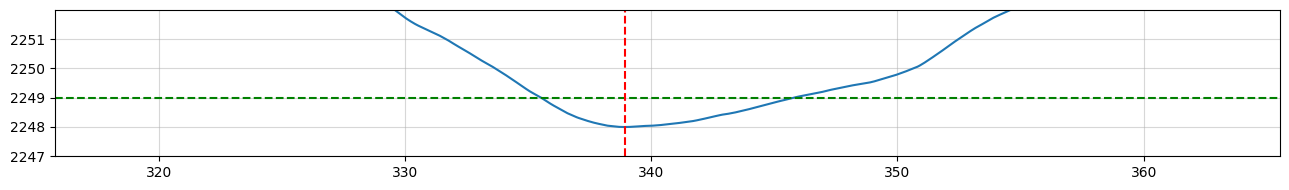

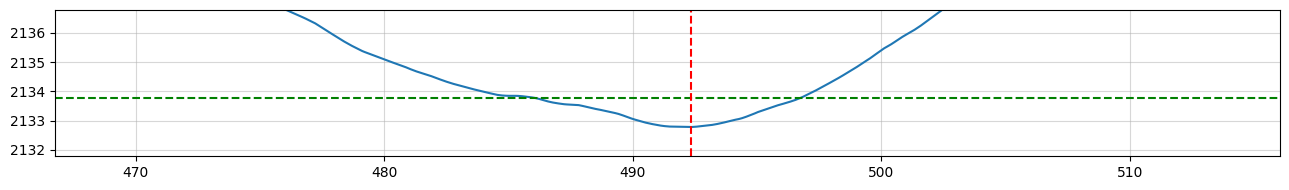

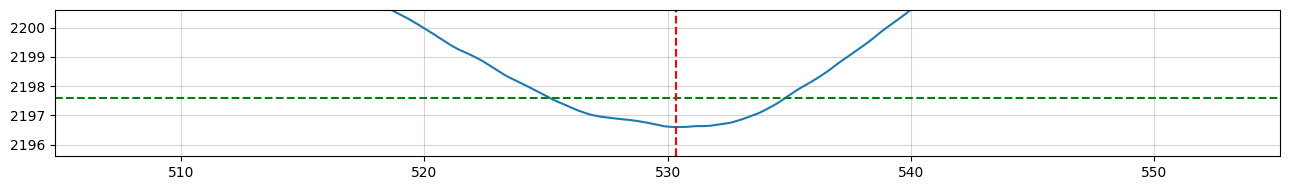

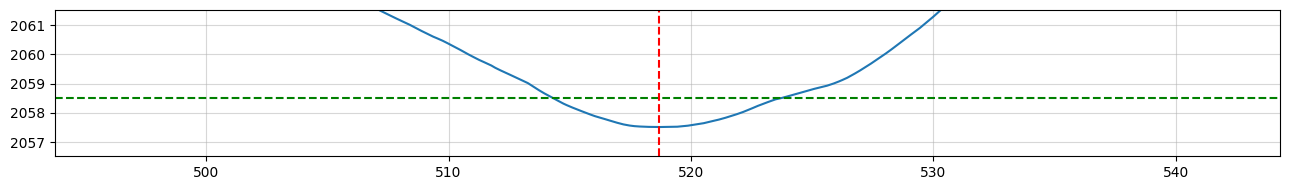

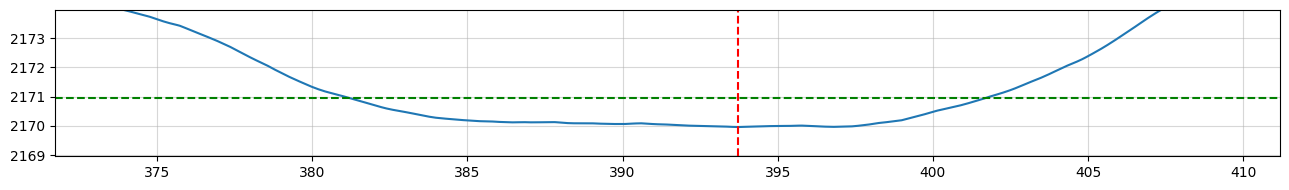

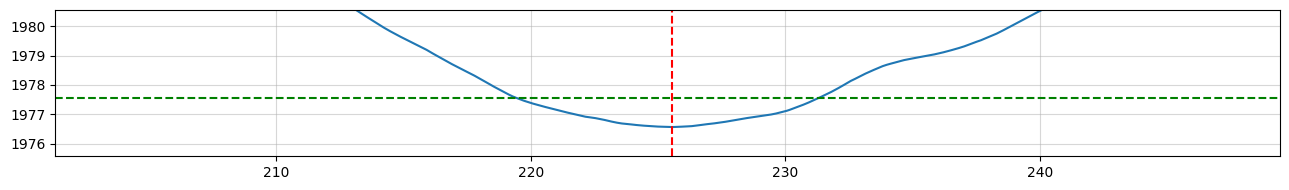

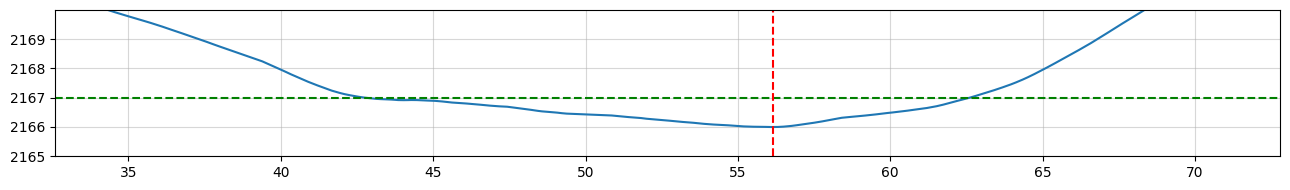

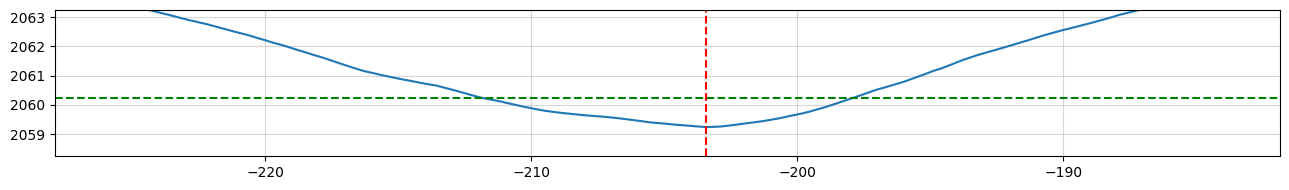

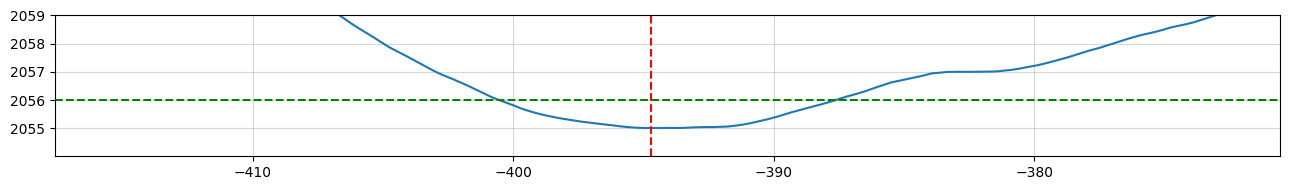

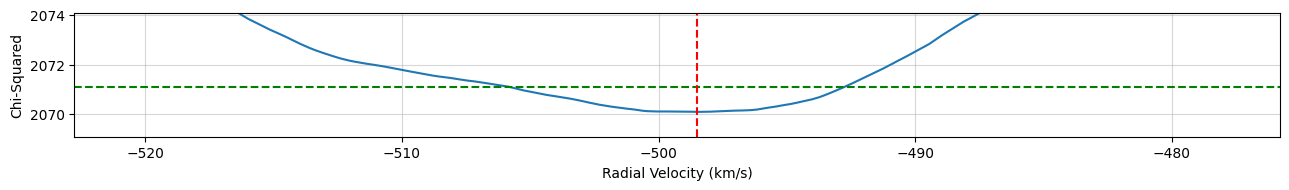

,Phase,Radial Velocity (km/s),Uncertainty (km/s)
0,-0.1405,-412.566257,8.610861
1,-0.0583,-165.991599,9.885989
2,0.0325,171.752175,8.155816
3,0.0998,338.938894,5.120512
4,0.1740,492.334233,5.360536
5,0.2310,530.328033,4.840484
6,0.3079,518.676868,4.735474
7,0.3699,393.714371,10.266027
8,0.4388,225.547555,5.945595
9,0.5008,56.160616,9.900990


In [62]:
def calculate_velocity_uncertainty(velocities, chi_squared):
    # Minimum chi-squared value
    chi_min = np.min(chi_squared)  
    min_index = np.argmin(chi_squared)  
    v_min = velocities[min_index]  
    # Threshold for 1-sigma confidence
    threshold = chi_min + 1
    # Find where chi-squared crosses the threshold
    crossing_indices = np.where(chi_squared <= threshold)[0]
    v_left = velocities[crossing_indices[-1]] 
    v_right = velocities[crossing_indices[0]] 
    # Uncertainty is the range around the minimum
    uncertainty_left = v_min - v_left
    uncertainty_right = v_right - v_min
    return v_min, uncertainty_left, uncertainty_right

velocity_uncertainties = []
radial_velocities = []
for i, phase in enumerate(GS_2000):
    flux = np.array(subtracted_fluxes[i][~mask_range])
    wavelength = np.array(data_dict[phase]["wavelength"][~mask_range])
    sigma = np.array(normalised_sigma[i][~mask_range])

    # Refine the search velocities around approx_vs
    search_vs = np.linspace(
        approx_vs[i] - 50, 
        approx_vs[i] + 50 , 
        10000
    )
    _, chi_squared = chi_minimser(flux, wavelength, sigma, search_vs)
    
    # Calculate velocity and uncertainties
    v_min, uncertainty_left, uncertainty_right = calculate_velocity_uncertainty(search_vs, chi_squared)
    ## Plot the uncertainty and velocity
    plt.figure(figsize=(13, 2))
    plt.plot(search_vs, chi_squared)
    plt.axhline(np.min(chi_squared) + 1, color='g', linestyle='--')
    plt.axvline(v_min, color='r', linestyle='--')
    if i == len(GS_2000) - 1:
        plt.xlabel("Radial Velocity (km/s)")
        plt.ylabel("Chi-Squared")
    plt.xlim(v_min - uncertainty_left - 30,v_min + uncertainty_right + 30)
    plt.ylim(np.min(chi_squared) - 1,np.min(chi_squared) + 4)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()
    velocity_uncertainties.append((np.abs(uncertainty_left)+np.abs(uncertainty_right))/2)
    radial_velocities.append(v_min)
    
## Define a dataframe to show the data
data = {
    "Phase": phases,  # List of phases
    "Radial Velocity (km/s)": radial_velocities,  # Corresponding radial velocities
    "Uncertainty (km/s)": velocity_uncertainties,  # Corresponding uncertainties
}

# Create the DataFrame
radial_velocity_table = pd.DataFrame(data)
radial_velocity_table.head(13)


By averaging the asymmeteric chi^2 distributions we can determine the uncertainty in the radial velocities from the graph. These are presented here in a table.

$
\large \text{Plot: Fitting } V(\phi) \text{ to data and showing error bars}
$

$$
V(\phi) = \gamma + K_x  \sin{( 2\,\pi\,\phi)} + K_y 
\cos{(2\,\pi\,\phi)}
$$

We fit the data to a periodic wave using iterative optimal scaling. In order to deterine the semi-amplitude of the radial velocity.

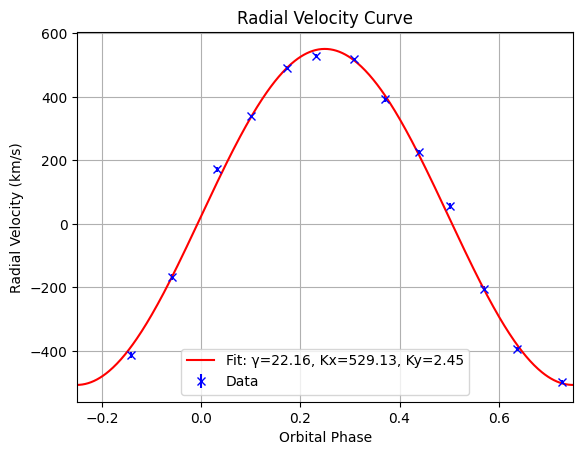

In [63]:


# Velocity uncertainties (convert to positive if needed)
velocity_uncertainties = np.array(velocity_uncertainties)
# Define the periodic velocity model
def velocity_model(phi, gamma, Kx, Ky):
    """Periodic velocity model"""
    return gamma + Kx * np.sin(2 * np.pi * phi) + Ky * np.cos(2 * np.pi * phi)

# Iterative scaling function
def iterative_scaling(phases, velocities, errors, tol=1e-6, max_iter=100):
    """Iterative scaling for fitting the velocity model"""
    # Initial guesses
    gamma = np.mean(velocities)  # Approximate systemic velocity
    Kx, Ky = 0, 0
    prev_residual = np.inf  # Residual for convergence

    for _ in range(max_iter):
        # Compute modeled velocities
        modeled_velocities = velocity_model(phases, gamma, Kx, Ky)

        # Calculate residuals
        residuals = velocities - modeled_velocities
        chi_squared = np.sum((residuals / errors) ** 2)

        # Break if converged
        if abs(prev_residual - chi_squared) < tol:
            break

        prev_residual = chi_squared

        # Update parameters iteratively using weighted residuals till values converge
        weights = 1 / errors**2
        gamma += np.sum(weights * residuals) / np.sum(weights)
        Kx += np.sum(weights * residuals * np.sin(2 * np.pi * phases)) / np.sum(weights)
        Ky += np.sum(weights * residuals * np.cos(2 * np.pi * phases)) / np.sum(weights)

    return gamma, Kx, Ky

# Perform iterative scaling
gamma, Kx, Ky = iterative_scaling(phases, radial_velocities, velocity_uncertainties)

# Generate the fitted velocity curve
phi_fine = np.linspace(-0.5, 1.5, 1000) 
fitted_velocities = velocity_model(phi_fine, gamma, Kx, Ky)

# Plot the results
plt.errorbar(phases, radial_velocities, yerr=velocity_uncertainties, fmt='x', label='Data', color='blue')
plt.plot(phi_fine, fitted_velocities, label=f'Fit: γ={gamma:.2f}, Kx={Kx:.2f}, Ky={Ky:.2f}', color='red')
plt.xlabel("Orbital Phase")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Radial Velocity Curve")
plt.xlim(-0.25,0.75)
plt.legend()
plt.grid()
plt.show()


We can see the data estimated velocities fit very well the data as we would expect since it must be in orbit. We can also here see the radial velocities plot as a function of phase with their associated uncertainty.

In order to find the radial velocity semi-amplitude In order to do this we must use the following formula to determine the uncertainty:

$$	K = \left( {K_x}^2 + {K_y}^2 \right)^{1/2}
$$

In order to get the uncertainty in the amplitude, we must use the inverse Hessian matrix found during our minimization process, as we need to propagate the errors in $C$ and $S$. These are not orthogonal, and hence the uncertainty is given by:

$$
\Delta K = \sum_{i,j} \left( \frac{\partial K}{\partial p_i} \right) \left( \frac{\partial K}{\partial p_j} \right) \text{Cov}(p_i, p_j)
$$

##### Computed derivatives are:

$$
\frac{\partial K}{\partial{K_x}} = \frac{K_x}{K} \quad \quad \quad \frac{\partial K}{\partial K_y} = \frac{K_y}{K}
$$


In [64]:
def helpful_matrix(phases):
    """Compute the matrix for the velocity model"""
    # Three parameters: gamma, Kx, Ky
    A = np.zeros((len(phases), 3))  
    # Partial derivative with respect to gamma
    A[:, 0] = 1  
    # Partial derivative with respect to Kx
    A[:, 1] = np.sin(2 * np.pi * phases) 
    # Partial derivative with respect to Ky
    A[:, 2] = np.cos(2 * np.pi * phases) 
    return A

def compute_uncertainties(phases, velocities, errors, gamma, Kx, Ky):
    """Compute the uncertainties of the fit parameters"""
    # Residuals
    modeled_velocities = velocity_model(phases, gamma, Kx, Ky)
    residuals = velocities - modeled_velocities
    # find matrix
    A = helpful_matrix(phases)
    # Weight matrix 
    W = np.diag(1 / errors**2)
    # Covariance matrix is the inverse of this
    ATA = A.T @ W @ A
    return ATA

In [65]:
K = np.sqrt(Kx**2 + Ky**2)

ATA = compute_uncertainties(phases, radial_velocities, velocity_uncertainties, gamma, Kx, Ky)
covariance_matrix = np.linalg.inv(ATA) 

# Extract variances and covariance for Kx and Ky
variance_Kx = covariance_matrix[1, 1]  # Variance of Kx
variance_Ky = covariance_matrix[2, 2]  # Variance of Ky
cov_Kx_Ky = covariance_matrix[1, 2]    # Covariance between Kx and Ky

# Calculate the amplitude K
K = np.sqrt(Kx**2 + Ky**2)

# Propagate uncertainty, including covariance
K_uncertainty = np.sqrt(
    (Kx / K)**2 * variance_Kx +
    (Ky / K)**2 * variance_Ky +
    2 * (Kx / K) * (Ky / K) * cov_Kx_Ky
)

# Print results
print(f"Semi-amplitude of Radial Velocity (K) = {K:.2f} km/s ± {K_uncertainty:.2f}")

Semi-amplitude of Radial Velocity (K) = 529.13 km/s ± 2.60


Having found the Radial Velocity we can now use this and the mass equation below to estimate the Mass of the compact object or black hole candidate.

$$
f(M_x) = \frac{M_X \, (\sin{i})^3}{(1 + q)^2} = \frac{K^3 \, P}{2 \pi G}.
$$

### Terms of the equation:
- **$f(M_x)$**:  
  The mass function, a helpful intermediary.

- **$M_x$**:  
  The mass of the compact object in our system

- **$\sin{i}$**:  
  The sine of the orbital inclination angle $i$, where $i$ is the angle between the orbital plane and the line of sight. 

- **$q$**:  
  The mass ratio of the two bodies in the system, defined as $q = M_c / M_x$.

- **$K$**:  
  The radial velocity semi-amplitude of the observed star. It represents the maximum Doppler shift of the spectral lines of the donor star due to its orbital motion around the center of mass.

- **$P$**:  
  The orbital period of the binary system, measured in seconds.

The function above will allow us to measure the mass of the compact object by calculating $f(M_x)$, the uncertainty in the function is calculated using the same formula above (5).

It's not clear to what the uncertainty of the orbital period, therefore in my initial calculation I assume it is negligble and after set it to 0.0001 as in the HW2 with the assumption that similar precision is used here.

In [66]:
## Define important parameters 
K_ms = K* 10**3
K_ms_uncertainty = K_uncertainty * 10**3
G = 6.67430e-11 
P  = 0.3440915*24*60*60
F_x = (K_ms)**3* P/ (2* np.pi * G)

## Assuming K and P are independent calculate the uncertainty
sigma_F_x = np.sqrt((3 * (K_ms)**2 * P * K_ms_uncertainty)**2)

print(f"f(M_x) = {F_x}  ± {sigma_F_x}")

f(M_x) = 1.0502593330960314e+31  ± 6.489886385264378e+19


We can solve for q, then find Mx, by taking the reciprocal and multiplying by m_c
of the first equation above.

$$
q(1 + q)^2 = \frac{M_C \, (\sin{i})^3}{f(M_x)}
$$

This equation can be solved using the cubic formula for $q$

Using some basic number as a preliminary guess we can calculte the M_x in solar masses

In [67]:
### Assume i = 90 and M_c = 0.5 * M.
M_dot =  1.989e30 
Mc = 0.5 * M_dot

def compute_q(var):
    # Define the components of the expression
    sqrt_term = 3 * np.sqrt(3) * np.sqrt(27 * var**2 + 4 * var)
    numerator = sqrt_term + 27 * var + 2
    term1 = (numerator**(1/3)) / (2**(1/3))
    term2 = (2**(1/3)) / (numerator**(1/3))
    
    # Compute q
    q = (1/3) * (term1 + term2 - 2)
    return q
## Calculate the Mass of the compact object
var = (Mc * 1) /(F_x)
q = compute_q(var)
Mx = 1/q * Mc
## Print the inital estimate
print(f"Initial Mass calculation {Mx/M_dot} Solar masses")

Initial Mass calculation 6.170715903338372 Solar masses


This suggests that it could very likely be a blackhole, in order to investiate further monte carlo simulation is done in order sample a range of possible masses based on the variables.

 The absence of eclipses suggests a range of $
50^\circ < i < 80^\circ$ should be used. A K5 main sequence star has a mass around $0.60M_{\odot}$ to  $0.60M_{\odot}$ we will sample uniformly around here. Note it is possible a normal sampling would be better but I'm not sure exaclty how these stars are separated(i.e. what the distriubtion of masses looks like) so using uniform for precaution.
 

This monte carlo code samples lots of different values for each of the unknowns either around their uncertainty or over a predicted set of possible values. in this way it allows us to determine the probability of the compact object or back hole candidate of having a mass in x range. 

Probability of Mx > 3 Solar masses: 1.0000


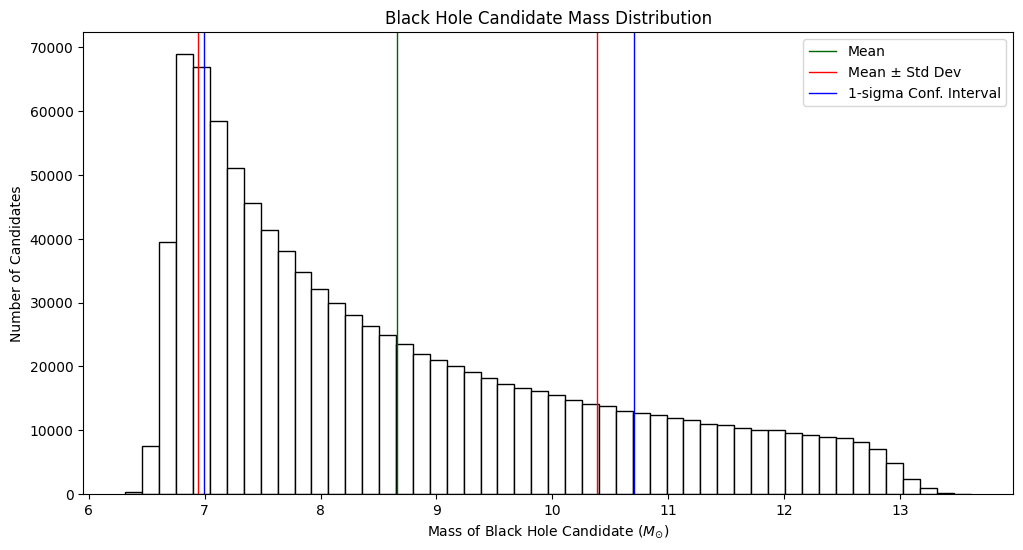

In [68]:
N = 1000000
i_min = np.radians(50)
i_max = np.radians(80)
cosi_s = np.random.uniform(np.cos(i_min),np.cos(i_max),N)
i_s = np.arccos(cosi_s)
sini = np.sin(i_s)
M_c = np.random.uniform(0.6,0.75,N)*M_dot
K_s = np.random.normal(K_ms,K_ms_uncertainty,N)
P_s = np.random.normal(P,0.0001,N)


Mx_s = np.zeros([N])


### loop over each sample and calculate the masses
for i in range(N):
    ## calculation done relative to mass of sun 1.989*10^30
    F_x = (P_s[i] * K_s[i]**3) / (2 * np.pi * G)
    var = (M_c[i] * sini[i]**3) /(F_x)
    q = compute_q(var)
    Mx = M_c[i]/q
    Mx_s[i] = Mx/M_dot

p = 1
correction_factor = 1/(1+((p*(p-2))/(4*(N-1))))

Mx_mean = np.mean(Mx_s)
Mx_sigma = np.sqrt(np.var(Mx_s,ddof=1)) * correction_factor
sorted_Mx = np.sort(Mx_s)
Mx_16th, Mx_84th = sorted_Mx[int(0.16 * N)], sorted_Mx[int(0.84 * N)]


fig, ax2 = plt.subplots(1,1, figsize = (12,6))
ax2.hist(Mx_s, bins = 50,color='white', edgecolor="black")
ax2.set_title("Black Hole Candidate Mass Distribution")
ax2.set_xlabel("Mass of Black Hole Candidate ($M_{\odot}$)")
ax2.set_ylabel("Number of Candidates")
ax2.axvline(Mx_mean, color='darkgreen', linewidth=1, label='Mean')
ax2.axvline(Mx_mean + Mx_sigma, color='red',linewidth=1, label='Mean ± Std Dev')
ax2.axvline(Mx_mean - Mx_sigma, color='red', linewidth=1)
ax2.axvline(Mx_16th, color='blue', linewidth=1, label='1-sigma Conf. Interval')
ax2.axvline(Mx_84th, color='blue', linewidth=1)
ax2.legend()

## Probability of M_x > 3 
P_Mx_s = len(Mx_s[Mx_s > 3])/ N 
print(f"Probability of Mx > 3 Solar masses: {P_Mx_s:.4f}")

Therefore I conclude from my analysis that the compact object is a black hole as it is too large to be a neutron star, with theory suggesting these can be at maximum 3 solar masses. As you can also see in the graph, our sampling never predicts a mass within the range of neutron star.